### CX Calibration with HPO under the new code architecture / workflow (DEC 2023)

In [1]:
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import yaml
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from quantumenvironment import QuantumEnvironment
from agent import Agent
from gate_level_abstraction import gate_q_env_config
from helper_functions import load_agent_from_yaml_file
from ppo import make_train_ppo

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'delay', 'z', 'h', 'x', 'id', 'sx', 'sdg', 'tdg', 'measure', 't', 'reset', 's', 'rz'}
  q1: {'delay', 'z', 'h', 'x', 'id', 'sx', 'sdg', 'tdg', 'measure', 't', 'reset', 's', 'rz'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'cr45m', 'ecr'}
  (1, 0): {'cr45p', 'cr45m', 'ecr'}
)>
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done fo

In [2]:
gate_q_env_config.action_space

Box(-1.0, 1.0, (7,), float32)

In [3]:
# from gymnasium.wrappers.rescale_action import RescaleAction

# min_action = 0
# max_action = 1
# wrapped_env = RescaleAction(q_env, min_action=min_action, max_action=max_action)

### Import HPO Params from YAML file

In [4]:
ppo_params, network_config, hpo_config = load_agent_from_yaml_file('agent_config.yaml')

In [5]:
ppo_params

{'run_name': 'test',
 'n_updates': 1,
 'n_epochs': 12,
 'batch_size': 24,
 'learning_rate': 0.01,
 'gamma': 0.99,
 'gae_lambda': 0.95,
 'ent_coef': 0.01,
 'vf_coef': 0.5,
 'max_grad_norm': 5.0,
 'clip_range_vf': True,
 'clip_range': 0.2}

In [6]:
network_config

{'optimizer': 'adam',
 'n_units': [64, 64],
 'activation': 'tanh',
 'include_critic': True,
 'normalize_advantage': True,
 'checkpoint_dir': 'checkpoints'}

In [7]:
hpo_config

{'num_trials': 3,
 'n_updates': [200, 1000],
 'n_epochs': [8, 25],
 'minibatch_size': [10, 16, 24, 32, 48, 64, 96, 128],
 'batchsize_multiplier': [2, 12],
 'learning_rate': [0.0001, 0.02],
 'gamma': [0.95, 0.999],
 'gae_lambda': [0.9, 0.999],
 'ent_coef': [5e-05, 0.001],
 'v_coef': [0.25, 0.75],
 'max_grad_norm': [0.005, 0.9],
 'clip_value_loss': True,
 'clip_value_coef': [0.1, 0.3],
 'clip_ratio': [0.1, 0.3]}

SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j])


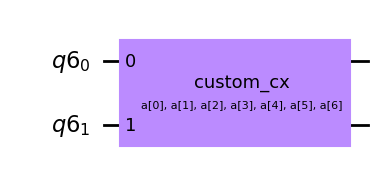

In [8]:
q_env = QuantumEnvironment(gate_q_env_config)
q_env
q_env.parameters.params
q_env.circuit_truncations[0].draw('mpl')

In [9]:
def objective(trial):
    # Fetch hyperparameters from the trial object

    agent_config = {
        'N_UPDATES': trial.suggest_int('N_UPDATES', hpo_config['n_updates'][0], hpo_config['n_updates'][1]),
        'N_EPOCHS': trial.suggest_int('N_EPOCHS', hpo_config['n_epochs'][0], hpo_config['n_epochs'][1]),
        'MINIBATCH_SIZE': trial.suggest_categorical('MINIBATCH_SIZE', hpo_config['minibatch_size']),
        'BATCHSIZE_MULTIPLIER': trial.suggest_int('BATCHSIZE_MULTIPLIER', hpo_config['batchsize_multiplier'][0], hpo_config['batchsize_multiplier'][1]),
        'LR': trial.suggest_float('LR', hpo_config['learning_rate'][0], hpo_config['learning_rate'][1], log=True),
        'GAMMA': trial.suggest_float('GAMMA', hpo_config['gamma'][0], hpo_config['gamma'][1]),
        'GAE_LAMBDA': trial.suggest_float('GAE_LAMBDA', hpo_config['gae_lambda'][0], hpo_config['gae_lambda'][1]),
        'ENT_COEF': trial.suggest_float('ENT_COEF', hpo_config['ent_coef'][0], hpo_config['ent_coef'][1]),
        'V_COEF': trial.suggest_float('V_COEF', hpo_config['v_coef'][0], hpo_config['v_coef'][1]),
        'GRADIENT_CLIP': trial.suggest_float('GRADIENT_CLIP', hpo_config['max_grad_norm'][0], hpo_config['max_grad_norm'][1]),
        'CLIP_VALUE_COEF': trial.suggest_float('CLIP_VALUE_COEF', hpo_config['clip_value_coef'][0], hpo_config['clip_value_coef'][1]),
        'CLIP_RATIO': trial.suggest_float('CLIP_RATIO', hpo_config['clip_ratio'][0], hpo_config['clip_ratio'][1]),
    }

    # Allowing for a range of possible batchsize / minibatch_size combinations by ensuring that batchsize is a multiple of minibatch_size
    agent_config['BATCHSIZE'] = agent_config['MINIBATCH_SIZE'] * agent_config['BATCHSIZE_MULTIPLIER']
    
    agent_config['CLIP_VALUE_LOSS'] = hpo_config['clip_value_loss']

    # Add network-specific hyperparameters that are not part of HPO scope
    agent_config['OPTIMIZER'] = network_config['optimizer']
    agent_config['N_UNITS'] = network_config['n_units']
    agent_config['ACTIVATION'] = network_config['activation']
    agent_config['INCLUDE_CRITIC'] = network_config['include_critic']
    agent_config['NORMALIZE_ADVANTAGE'] = network_config['normalize_advantage']

    agent_config['RUN_NAME'] = ppo_params['run_name']


    q_env = QuantumEnvironment(gate_q_env_config)  # Initialize your environment
    q_env.batch_size = agent_config['BATCHSIZE'] # Overwrite the batch_size of the environment with the one from the agent_config

    train_fn = make_train_ppo(agent_config, q_env)
    training_results = train_fn(total_updates=agent_config['N_UPDATES'], print_debug=True, num_prints=50)

    # Save the action vector associated with this trial's fidelity for future retrieval
    trial.set_user_attr('action_vector', training_results['action_vector'])

    # Use a relevant metric from training_results as the return value
    last_ten_percent = int(0.1 * agent_config['N_UPDATES'])
    
    return training_results['avg_return'][-last_ten_percent]  # Return a metric to minimize or maximize

In [11]:
import optuna

num_HPO_trials = hpo_config['num_trials']
print('num_HPO_trials: ', num_HPO_trials)

def optimize_hyperparameters():
    study = optuna.create_study(direction="maximize")  # or 'minimize' depending on your metric
    study.optimize(objective, n_trials=num_HPO_trials)  # Number of hyperparameter configurations to try

    print("Best trial:")
    best_trial = study.best_trial

    print("  Value: ", best_trial.value)
    print("  Parameters: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    best_action_vector = best_trial.user_attrs['action_vector']
    print(f'The best action vector is: {best_action_vector}')

optimize_hyperparameters()

 99%|█████████▊| 900/912 [04:17<00:03,  3.35it/s]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])


 99%|█████████▉| 901/912 [04:18<00:03,  3.36it/s]

mean tensor([-0.0022,  0.0460, -0.0476, -0.0017,  0.0012, -0.0017, -0.0047])
Average return: 0.9995445224275161
DFE Rewards Mean: 0.9995445224275161
DFE Rewards standard dev 0.0028176837049266787
Returns Mean: 9.744822
Returns standard dev 3.6910243
Advantages Mean: 0.5376935
Advantages standard dev 3.6910245
Fidelity History: []
SparsePauliOp(['II', 'IY', 'XI', 'XY'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


 99%|█████████▉| 902/912 [04:18<00:02,  3.40it/s]

mean tensor([ 0.0007,  0.0578, -0.0503,  0.0128,  0.0210, -0.0033, -0.0024])
Average return: 0.9976653621972209
DFE Rewards Mean: 0.9976653621972209
DFE Rewards standard dev 0.005766842944271656
Returns Mean: 8.424471
Returns standard dev 3.9890907
Advantages Mean: -0.5099399
Advantages standard dev 3.9890907
Fidelity History: []
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


 99%|█████████▉| 903/912 [04:18<00:02,  3.45it/s]

mean tensor([ 4.7941e-05,  5.5653e-02, -5.0078e-02,  1.0215e-02,  1.5083e-02,
        -1.9786e-03, -5.2953e-03])
Average return: 0.9982839707476114
DFE Rewards Mean: 0.9982839707476114
DFE Rewards standard dev 0.005355618982158141
Returns Mean: 8.745056
Returns standard dev 3.9956524
Advantages Mean: -0.22813165
Advantages standard dev 3.9956527
Fidelity History: []
SparsePauliOp(['II', 'IY', 'XI', 'XY'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


 99%|█████████▉| 904/912 [04:18<00:02,  3.47it/s]

mean tensor([ 0.0015,  0.0583, -0.0507,  0.0147,  0.0215, -0.0019, -0.0046])
Average return: 0.9981867604154281
DFE Rewards Mean: 0.9981867604154281
DFE Rewards standard dev 0.005861345916191353
Returns Mean: 8.63939
Returns standard dev 4.006749
Advantages Mean: -0.1806015
Advantages standard dev 4.0067496
Fidelity History: []
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j])


 99%|█████████▉| 905/912 [04:19<00:02,  3.48it/s]

mean tensor([-0.0012,  0.0377, -0.0484, -0.0140, -0.0185, -0.0016, -0.0087])
Average return: 0.997667546874855
DFE Rewards Mean: 0.997667546874855
DFE Rewards standard dev 0.00629488271598039
Returns Mean: 8.457119
Returns standard dev 4.093584
Advantages Mean: -0.96375453
Advantages standard dev 4.093584
Fidelity History: []
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[ 0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j])


 99%|█████████▉| 906/912 [04:19<00:01,  3.50it/s]

mean tensor([-0.0009,  0.0549, -0.0495,  0.0104,  0.0174, -0.0039, -0.0043])
Average return: 0.9977913923802786
DFE Rewards Mean: 0.9977913923802786
DFE Rewards standard dev 0.005655179098085721
Returns Mean: 8.634026
Returns standard dev 4.041388
Advantages Mean: -0.036062866
Advantages standard dev 4.0413876
Fidelity History: []
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


 99%|█████████▉| 907/912 [04:19<00:01,  3.52it/s]

mean tensor([-0.0011,  0.0521, -0.0500,  0.0089,  0.0140, -0.0036, -0.0040])
Average return: 0.999049964027493
DFE Rewards Mean: 0.999049964027493
DFE Rewards standard dev 0.004710204739894991
Returns Mean: 9.201946
Returns standard dev 3.9629574
Advantages Mean: 0.5226537
Advantages standard dev 3.9629576
Fidelity History: []
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[ 0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j])


100%|█████████▉| 908/912 [04:20<00:01,  3.52it/s]

mean tensor([-4.7971e-05,  5.2625e-02, -5.1851e-02,  1.0630e-02,  1.6369e-02,
        -4.0266e-03, -4.0304e-03])
Average return: 0.9980568757263895
DFE Rewards Mean: 0.9980568757263895
DFE Rewards standard dev 0.005034210603770489
Returns Mean: 8.726699
Returns standard dev 3.9966807
Advantages Mean: -0.010588691
Advantages standard dev 3.9966807
Fidelity History: []
SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[ 0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j])


100%|█████████▉| 909/912 [04:20<00:00,  3.56it/s]

mean tensor([-0.0020,  0.0462, -0.0495,  0.0002,  0.0055, -0.0038, -0.0043])
Average return: 0.9992192771938784
DFE Rewards Mean: 0.9992192771938784
DFE Rewards standard dev 0.002746191004291202
Returns Mean: 9.40489
Returns standard dev 3.715283
Advantages Mean: 0.47125363
Advantages standard dev 3.7152832
Fidelity History: []
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


100%|█████████▉| 910/912 [04:20<00:00,  3.58it/s]

mean tensor([-0.0025,  0.0330, -0.0491, -0.0145, -0.0129, -0.0027, -0.0064])
Average return: 0.9993436522774454
DFE Rewards Mean: 0.9993436522774454
DFE Rewards standard dev 0.0033830025964986066
Returns Mean: 9.490257
Returns standard dev 3.8231738
Advantages Mean: 0.0989994
Advantages standard dev 3.8231735
Fidelity History: []
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


100%|█████████▉| 911/912 [04:21<00:00,  3.06it/s]

mean tensor([-0.0011,  0.0487, -0.0500,  0.0053,  0.0115, -0.0026, -0.0042])
Average return: 0.9989056529294591
DFE Rewards Mean: 0.9989056529294591
DFE Rewards standard dev 0.004081526458568236
Returns Mean: 9.06805
Returns standard dev 3.8646169
Advantages Mean: 0.1771698
Advantages standard dev 3.8646169
Fidelity History: []
SparsePauliOp(['II', 'IY', 'XI', 'XY'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


100%|██████████| 912/912 [04:21<00:00,  3.49it/s]
[I 2023-12-22 00:03:23,858] Trial 1 finished with value: 0.9986693971453353 and parameters: {'N_UPDATES': 912, 'N_EPOCHS': 18, 'MINIBATCH_SIZE': 128, 'BATCHSIZE_MULTIPLIER': 8, 'LR': 0.0003903079011240999, 'GAMMA': 0.9887099489877079, 'GAE_LAMBDA': 0.9590045076970539, 'ENT_COEF': 0.0005471174523443949, 'V_COEF': 0.5758135245575489, 'GRADIENT_CLIP': 0.899347922490556, 'CLIP_VALUE_COEF': 0.10152409730598705, 'CLIP_RATIO': 0.19937721898591096}. Best is trial 0 with value: 0.9988259775263758.


mean tensor([ 0.0016,  0.0518, -0.0481,  0.0117,  0.0147, -0.0034, -0.0028])
Average return: 0.9986693971453353
DFE Rewards Mean: 0.9986693971453353
DFE Rewards standard dev 0.00483800263187286
Returns Mean: 9.025321
Returns standard dev 3.962676
Advantages Mean: 0.18834224
Advantages standard dev 3.962676
Fidelity History: []
Best trial:
  Value:  0.9988259775263758
  Parameters: 
    N_UPDATES: 909
    N_EPOCHS: 17
    MINIBATCH_SIZE: 128
    BATCHSIZE_MULTIPLIER: 3
    LR: 0.0029252033669695905
    GAMMA: 0.9962966314094535
    GAE_LAMBDA: 0.967373466908538
    ENT_COEF: 0.0001981227424736241
    V_COEF: 0.3253160267290231
    GRADIENT_CLIP: 0.03947432757136103
    CLIP_VALUE_COEF: 0.1587478837588509
    CLIP_RATIO: 0.25295220269273205
The best action vector is: [ 0.00612166 -0.4763572   0.5183992  -0.0056716  -0.01340097  0.01501047
  0.01068227]
